# Basic Usage Tutorial

Adam Klie (last updated: *07/08/2023*)

In this tutorial, we illustrate a basic end-to-end EUGENe workflow that trains and interprets a single task regression model on a [published dataset of plant promoters](https://www.nature.com/articles/s41477-021-00932-y). If you are just starting out with EUGENE, you are in the right place! This tutorial will walk you through the steps of preparing the data, training a single task regression model, and interpreting that trained model.

You can also find this tutorial as a Jupyter notebook in the `docs` [directory of the EUGENE repository](https://github.com/cartercompbio/EUGENe/blob/main/docs/basic_usage_tutorial.ipynb). You can copy this notebook from there, or just copy and paste the code in each cell into a new notebook to follow along. Just make sure to have [installed EUGENe](https://eugene-tools.readthedocs.io/en/latest/installation.html) in your environment before you start!

> **Warning**:
> Before you start! Running this notebook without a GPU on this data is feasible but will be very slow. We'd recommend using [Google Colab](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) if you don't have access to your own GPU.


> **Note**:
> We've noticed that for some IDE configurations, plots do not render in a Jupyter notebook unless you include the `%matplotlib inline` magic command. If you are having trouble rendering plots, make sure you have this line in your notebook or use `plt.show()` after each plot.

In [ ]:
%matplotlib inline

In [ ]:
!pip install 'eugene-tools'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 90.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.9/687.9 kB 48.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.4/460.4 kB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 80.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of seqexplainer to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of seqpro to determine which version is compatible with othe

In [ ]:
!pip install torchmetrics==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.6/529.6 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.4.2
    Uninstalling torchmetrics-1.4.2:
      Successfully uninstalled torchmetrics-1.4.2


## Configuring

To make the sometimes painful process of keeping track of global parameters and input/output file paths easier, we usually like to set these through EUGENE's `settings` up front. This will control the default directories for things like:

- Data downloads with `seqdatasets`
- Model configuration files (i.e. EUGENe will know where to look for these files without you having to specify the full path every time)
- Model logs, checkpoints, and predictions
- Figures and plots

These small quality of life features can go a long way to preserve your sanity!

In [ ]:
# Change this to where you would like to save all your results
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/EUGENe")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/EUGENe'

In [ ]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading
For this tutorial, we will reproduce the prediction of promoter activity featured in [Jores et al., 2021](https://www.nature.com/articles/s41477-021-00932-y) that uses DNA sequences as input to predict [STARR-seq activity](https://en.wikipedia.org/wiki/STARR-seq). We first need to load this dataset. If the dataset is a "EUGENe benchmarking dataset", it can be loaded in through the `SeqDatasets` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#seqdatasets-access-to-common-datasets). Let's load the package first

In [ ]:
import seqdatasets

We can next use the `get_dataset_info()` function to get information about the datasets available as "EUGENe benchmarking datasets".

In [ ]:
# Check the dataset
seqdatasets.get_dataset_info()

,n_seqs,n_targets,metadata,url,description,author
dataset_name,,,,,,
random1000,1000,1,10 randomly generated binary labels (label_{0-...,https://github.com/cartercompbio/EUGENe/tree/m...,A randomly generated set of 1000 sequences wit...,Adam Klie (aklie@eng.ucsd.edu)
ray13,241357,244,"probe set (Probe_Set), bidning intensity value...",http://hugheslab.ccbr.utoronto.ca/supplementar...,This dataset represents an in vitro RNA bindin...,Hayden Stites (haydencooperstites@gmail.com)
farley15,163708,2,"barcode (Barcode), RPMs from each biological r...",https://zenodo.org/record/6863861#.YuG15uxKg-Q,This dataset represents SEL-seq data of C. int...,Adam Klie (aklie@eng.ucsd.edu)
deBoer20,100000000+,1,Variable depending on chosen file,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Gigantic parallel reporter assay data from ~10...,Adam Klie (aklie@eng.ucsd.edu)
jores21,147966,1,"set (set), species (sp), gene promoter came fr...",https://raw.githubusercontent.com/tobjores/Syn...,"This datast includes activity scores for 79,83...",Adam Klie (aklie@eng.ucsd.edu)
deAlmeida22,484052,4,Normalized enrichment scores for developmental...,https://zenodo.org/record/5502060/,This dataset includes UMI-STARR-seq data from ...,Adam Klie (aklie@eng.ucsd.edu)


We are in luck! The plant promoter dataset is available via the `jores21()` command. If you are requesting this dataset for the for the first time, it will be downloaded and loaded into a `SeqData` object automagically (and downloaded to your `settings.dataset_dir`).

In [ ]:
# Download the dataset to the dataset dir. We are using the promoters assayed in leaf promoters here
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Path /content/drive/MyDrive/EUGENe/tutorial_dataset/jores21 does not exist, creating new folder.
Finished downloading CNN_test_leaf.tsv
Finished downloading CNN_train_leaf.tsv
Zarr file not found. Creating new zarr file.


72158it [00:14, 5152.39it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

If you want to learn more about how you can use EUGENe to read from your standard genomics file formats or how we represents datasets in memory and on disk, check out the `SeqData` section of the [usage principles](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#seqdata) and the `SeqData` subpackage.

## Data Visualization
Data visualization is a key part of the EUGENe workflow. We can use the `plot` module to visualize aspects of our data such as the distribution of targets.

In [ ]:
from eugene import plot as pl

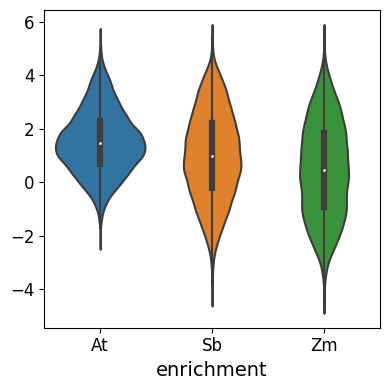

In [ ]:
# Plot the distribution of targets across the different species the promoters were derived from
pl.violinplot(sdata, vars=["enrichment"], groupby="sp", figsize=(4, 4))

## Preprocessing
Now that we have our data loaded in, we can preprocess it using EUGENe's `preprocess` module. This module wraps functionality from the `SeqPro` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#sequence-manipulation-is-handled-efficiently-by-seqpro) and includes several functions for common sequence preprocessing tasks.

### Sequence preprocessing
Our first preprocessing step will be to one-hot encode our sequences. One-hot encoding is a common way to represent sequences as a matrix of 0s and 1s for model training. We will pass in DNA as the vocab explicitly, but this is the default if not specified.

In [ ]:
from eugene import preprocess as pp

In [ ]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

print(sdata)

<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, _length, length, _ohe
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) uint8 0 0 0 1 0 0 1 ... 0 1 0 1 0 0 0


Let's also quickly set-up some identifiers for our sequences. This will come in handy during interpretation when we often want to visualize the importance of specific sequences.

In [ ]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

### Dataset preprocessing
As is standard machine learning practice, we also need to split our data into training, validation, and test sets. This dataset comes with 'train' and 'test' labels in the 'set' annotation.

In [ ]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

We also need to split the training sequences into train and validation sets. We can do this using EUGENe's `train_test_random_split` function

In [ ]:
# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

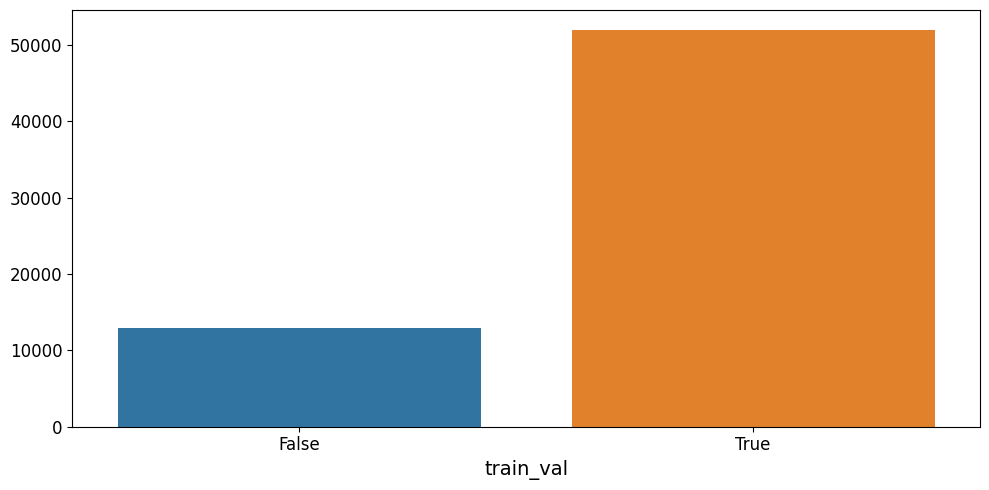

In [ ]:
# Check the split with a count plot
pl.countplot(sdata_train, vars="train_val", orient="h")

## Training
Now that we have our data ready, it's time to train our model! Training in EUGENe is done through the [PyTorch Lightning (PL) framework](https://www.pytorchlightning.ai/index.html). However PyTorch Lightning does not offer us much help with instantiating model architectures and initializing them. We will utilize EUGENE's library of neural network parts and architectures to do this.

### Instantiation and initialization
We first need to instantiate and initialize our model. We can use the `models` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#models-instantiate-and-initialize-neural-network-architectures) to do this.

In [ ]:
from eugene import models

EUGENe offers several options for instantiating a model architecture. Here we will load in a Hybrid architecture that contains convoultional blocks that feed into recurrent layers, finishing with fully connected ones. We have set up a configuration file that trains pretty well on this dataset that you can download from [here](https://github.com/ML4GLand/tutorials/blob/main/configs/hybrid.yaml).

We can then use the `load_config` function to load in this configuration file and initialize our model.

In [45]:
import torch
import torch.nn as nn

class IanCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Set the attributes
        self.input_len = 170  # Assuming your sequence length is 170
        self.output_dim = 1  # Binary classification

        # Convolutional layers
        self.conv1 = nn.Conv1d(4, 128, kernel_size=13)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=13)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=13)
        self.bn3 = nn.BatchNorm1d(128)
        #self.conv4 = nn.Conv1d(128, 256, kernel_size=13)
        #self.bn4 = nn.BatchNorm1d(256)
        #self.conv5 = nn.Conv1d(256, 512, kernel_size=13)
        #self.bn5 = nn.BatchNorm1d(512)


        # Dropout layer (Drop 50% of neurons during training)
        self.dropout_conv = nn.Dropout(p=0.4)  # Dropout for convolutional layers
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout for fully connected layers

        # Max Pooling and Global Average Pooling
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)  # First fully connected layer
        self.bn_fc1 = nn.BatchNorm1d(128)  # Batch normalization
        #self.fc2 = nn.Linear(256, 128)  # Second fully connected layer
        #self.bn_fc2 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc3 = nn.Linear(128, self.output_dim)  # Final output layer


    def forward(self, x):
        # First convolutional layer
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)  # Apply batch normalization
        x = self.dropout_conv(x)  # Apply dropout

        # Second convolutional layer
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)  # Apply batch normalization
        x = self.dropout_conv(x)  # Apply dropout

        # Third convolutional layer
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)  # Apply batch normalization
        x = self.dropout_conv(x)  # Apply dropout

        # Fourth convolutional layer
        #x = self.pool(torch.relu(self.conv4(x)))
        #x = self.bn4(x)  # Apply batch normalization
        #x = self.dropout_conv(x)  # Apply dropout

        # Fifth convolutional layer
        #x = self.pool(torch.relu(self.conv5(x)))
        #x = self.bn5(x)  # Apply batch normalization
        #x = self.dropout_conv(x)  # Apply dropout


        # Global average pooling to reduce the output size
        x = self.global_pool(x)  # Shape becomes (batch_size, 1024, 1)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 1024)

        # First fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.bn_fc1(x)  # Apply batch normalization
        x = self.dropout_fc(x)  # Apply dropout

        # Second fully connected layer
        #x = torch.relu(self.fc2(x))
        #x = self.bn_fc2(x)  # Apply batch normalization
        #x = self.dropout_fc(x)  # Apply dropout


        # Final output layer
        x = self.fc3(x)

        return x


# note: try making all filter sizes 128

In [46]:
model = models.SequenceModule(
    arch=IanCNN(),
    task="regression",
    loss_fxn="mse",
    optimizer="adam",
    optimizer_lr=0.001,
    metric="r2score",
    scheduler="reduce_lr_on_plateau",
    scheduler_kwargs={'patience':3}
)

In [ ]:
models.SequenceModule?

Different Model

In [47]:
# Initialize the weights
models.init_weights(model)

We can also print out a summary of the model architecture using the `summary` function. Note that the configuration file we read in here also defines the LightningModule from PL that will be used to train the model. For more details on how this works, check out the [tutorial on instantiating and initializing models](https://github.com/ML4GLand/tutorials/blob/main/eugene/models/instantiating_models.ipynb).

In [48]:
# Print out a summary of the model
model.summary()

Model: IanCNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 3}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | IanCNN  | 450 K  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
450 K     Trainable params
0         Non-trainable params
450 K     Total params
1.803     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode

### Model fitting

With a model intantiated and initialized, we are set up to fit our model to our plant promoters! We can do this through the `train` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#train-fit-parameters-to-your-data) in EUGENe

In [ ]:
from eugene import train

If you are using GPU accelerators on your machine, you can can use the `gpus` argument to set the number gpus you want to use. If left empty, EUGENe will try to infer the number of GPUs available. Training the model with a single GPU will take less than 5 minutes. Check out the API and docstring for the function below for more details on the arguments you can pass in.

In [49]:


train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=8,
    prefetch_factor=2,
    drop_last=False,
    name="ian_cnn",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/EUGENe/tutorial_logs/ian_cnn/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


We can see how our models trained over time by plotting a training summary. All you need to do is point the [training_summary](https://eugene-tools.readthedocs.io/en/latest/api/eugene.plot.training_summary.html#eugene.plot.training_summary) function to your the EUGENe logging directory.

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

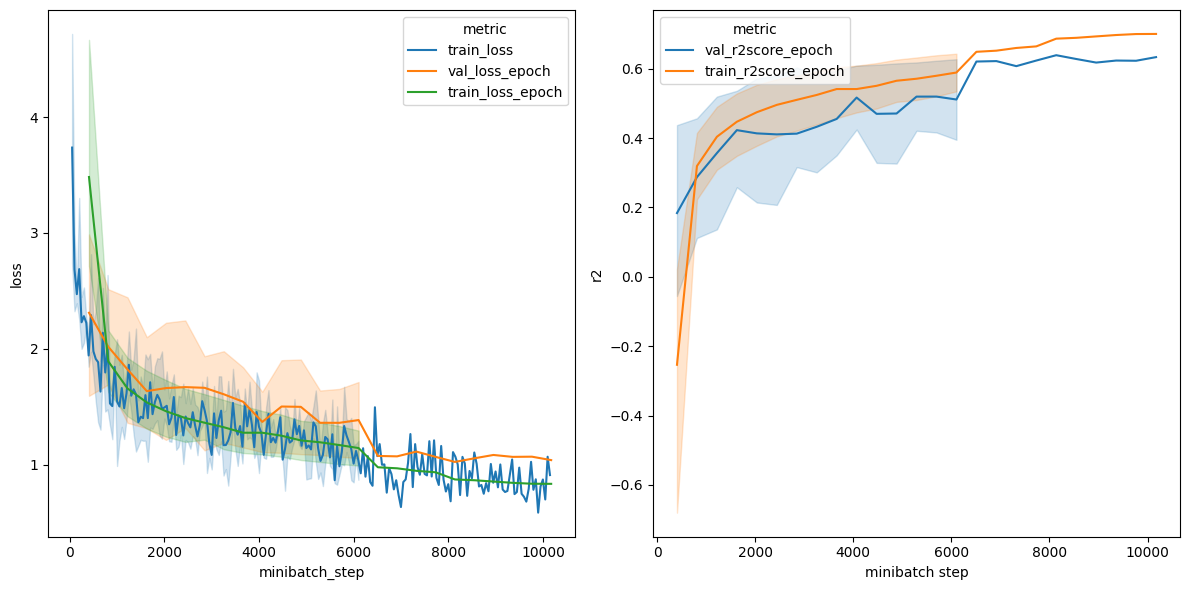

In [50]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "ian_cnn", "tutorial_model"), metric="r2")

## Evaluation
After the model's been trained, we can evaluate our performance on our held-out test data. This is done through the `evaluate` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#evaluate-validate-and-explore-models-on-new-data).

In [ ]:
from eugene import evaluate

We want to use our best model for evaluation. We can see from the training curve above that our model began overfitting the data after about 3000 training steps. Lucky for us, PyTorch Lightning keeps track of our best model for us! We can load this model in from the log directory like so

Our model is loaded in. Now let's make some predictions

In [51]:
# Use this best model to predict on the held-out data. This will store predictions in
evaluate.predictions_sequence_module(
    model,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=2048,
    in_memory=True,
    name="ian_cnn",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading ohe_seq and ['enrichment'] into memory


Predicting: |          | 0/? [00:00<?, ?it/s]

By default, these predictions are automatically stored in the SeqData object:

We know have predictions from our trained model! Let's look at a scatterplot to see how we did

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.37352599821361043 0.8725751107874941 0.6541574187628098
Sb 0.571297836859805 1.1639340478163906 0.808878292239713
Zm 0.6747413387802512 0.9903627365296842 0.826733247422973


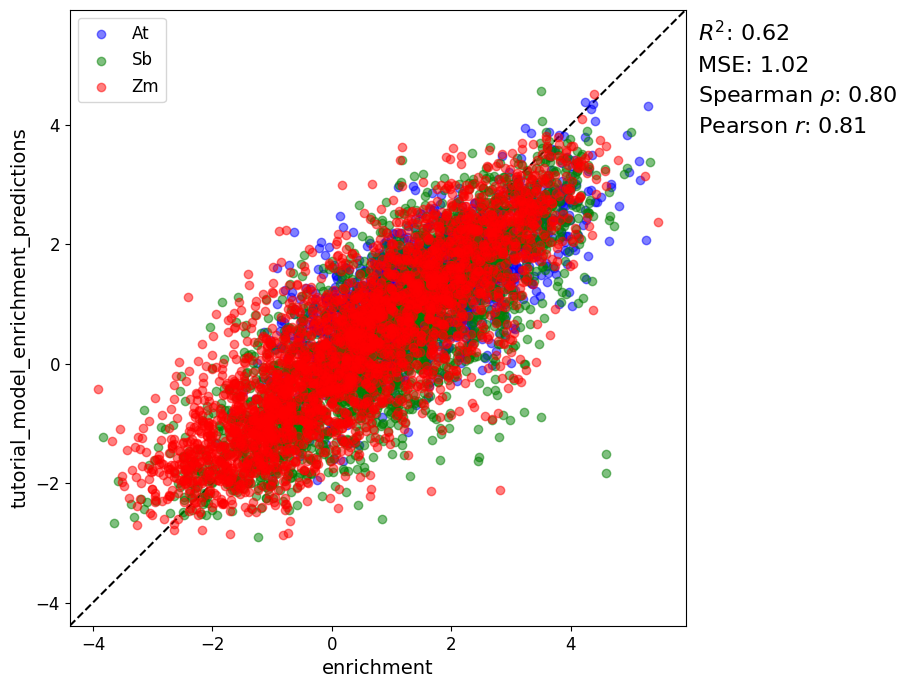

In [52]:
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

Not too shabby. We were able to train a pretty predictive model on this dataset with just DNA sequences as input!

---